In [24]:
import cv2
from matplotlib import pyplot as plt

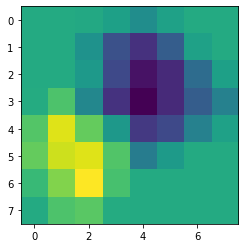

In [32]:
img = cv2.imread("fish.png")
YCbCr_img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
Y, Cr, Cb = cv2.split(YCbCr_img)

plt.imshow(Cr)


## Compressor de Imagens
O método utilizado nesse trabalho seguirá as diretrizes do método JPEG para imagens cromáticas (com cores). Será um método com perdas. Esse método pode ser dividido em 5 etapas:
1. Conversão do espaço de cores
2. Downsampling da chrominance
3. Aplicação da DCT
4. Quantização
5. Codificação de Símbolos utilzando Huffman


### Conversão do Espaço de Cores
Cada pixel de uma imagem colorida é dividida em 3 valores: R(red), G(green), B(blue). No método JPEG, esses valores são convertidos para Y(Luminance) Cb(blue chrominance) Cr(red chrominance). Isso é feito pois o olho humano é capaz de detectar brilho e luminâcia melhor do que detectar cores. Ao separar as cores desse modo, podemos, no próximo passo (Chrominance Downsampling) descartar algumas informações de Cb e Cr, de forma a já diminuir o tamanho necessário para cada pixel enquanto mantemos Y(que se refere ao brilho) intacto. Nesse caso, exploramos a redundânica psicovisual ao remover informações que não são facilmente detectadas, e mantendo aquelas que conseguimos perceber melhor.

In [ ]:
def convertRGBToYCbCr(imgInRGB):
    YCbCr_img = cv2.cvtColor(imgInRGB, cv2.COLOR_RGB2YCrCb)
    Y, Cr, Cb = cv2.split(YCbCr_img)
    return Y, Cb, Cr

### Chrominance Downsampling
Para realizar o downsampling, vamos pegar as matrizes referentes à Cb e Cr e então dividi-las em blocos de 2x2 pixels. Para cada bloco, fazemos a média dos valores dos 4 pixels, e então substituimos o bloco inteiro por apenas o valor calculado. Eliminamos, assim, grande parte da informação que nossos olhos mal conseguem perceber. Repare que desse modo diminuimos as matrizes Cb e Cr em 1/4 da imagem da original. Porém, mantivemos a matriz Y no seu tamanho original, que possui os valores relacionados ao brilho e luminânica.

In [ ]:
def downsamplingChrominance(chrominanceMatrix):
    pass

### Aplicação da DCT (Discrete Cosine Transform)
Nessa e na próxima etapa exploramos a característica do olho humano de não ser tão bom em distinguir elementos de alta frequência em uma imagem. Para cada seção da imagem, são "detectadas" regiões de alta frequência de luminância ou chrominance, que então podem ser descartados. Vamos às etapas do processo da aplicação da DCT.

- Para começar, dividimos a imagem em secções de 8x8 pixels.
- Então, diminuimos cada valor em 128 (o intervalo se torna (-128, +128)). -128 é preto enquanto que +128 é branco.
- Então, aplicamos a DCT em todas as secções 8x8 nas 3 matrizes Y, Cb e Cr.

Agora, temos todos os valores das três matrizes baseadas nas constantes definidas na DCT. Repare que ainda não realizamos nenhuma compressão.

In [ ]:
def getImageSections(colorMatrix):
    pass

def decreasePixelsValues(pixelSection):
    pass

def runDCT(pixelSection):
    pass

def applyDCT(colorMatrix):
    pixelSections = getImageSections(colorMatrix)
    
    for pixelSection in pixelSections:
        decreasePixelsValues(pixelSection)

    for pixelSection in pixelSections:
        runDCT(pixelSection)

    pass

### Quantização
Para então realizar a compreensão, passamos por cada bloco de 8x8 pixels e dividimos os valores (que já estão baseados nas constantes da DCT) pelos valores correspondes da tabela de quantização. A tabela de quantização possui valores mais altos no canto inferior direito( que correspondem as posições que possuem maior frequêcia na seção 8x8 de pixels). E então, arredondamos esses valores calculados para o inteiro mais próximo. Percebemos que muitos se tornam zeros, em especial, aqueles que possuem alta frequência. Portanto, estamos descartando dados da imagem original. Porém, são dados que nossos olhos mal conseguem notar. 

Podemos ter tabelas de quantização diferentes para a matriz Y e as matrizes Cb e Cr. Isso porque desejamos manter mais informções da matrix Y, então utilizamos valores menores na tabela de quantização. 

É nessa etapa também que é possível controlar o nível de compressão, com valores mais altos na tabela de quantização comprimindo mais a imagem, enquanto que valores menores mantém a imagem menos alterada.

In [ ]:
Y_TABLE = []
CHR_TABLE = []

def runQuantization(pixelSection, table):
    pass

### Codificação de Símbolos
Basta agora codificar de uma forma mais "esperta" e suscinta os valores de cada pixel da imagem. Para cada seção de pixels, iteramos em forma de zigue zague (pois é mais provável que valores não nulos estejam no canto superior esquerdo da seção) e então aplicamos um algoritmo de "comprimento", que vai substituir os valores iguais por apenas um deles e o número de ocorrências. Depois, aplicamos a codificação de Huffman para gerar um código baseado na probabilidade de cada um dos valores. 

In [ ]:
def runLengthAlgorithm(pixelSection):
    pass

def runHuffmanEncoding(lengthRes):
    pass

def encodePixelSection(pixelSection):
    lengthRes = runLengthAlgorithm(pixelSection)
    huffmanRes = runHuffmanEncoding(lengthRes)
    return huffmanRes

Pronto! Agora a imagem está codificada. Um exemplo de seção de 8x8 pixels pode ser visualizada abaixo.

### Descomprimindo a Imagem
O processo de descompressão é simples, basta realizar o processo de compressão na ordem inversa. As etapas estão listadas a seguir:
1. Lemos o arquivo comprimido, e então separamos as secções de pixels referentes a cada matrix Y, Cb e Cr.

In [ ]:
def readFileAndGetPixelSections(filename):
    pass

2. Para cada secção, decodificamos utilizando o decodificador de huffman.

In [ ]:
def decodeFromHuffman(encodedPixelSection):
    pass

3. Então, reconstruimos a matriz 8x8 de acordo com a decodificação do algoritmo de comprimento.

In [ ]:
def getPixelSectionMatrix(pixelSectionLength):
    pass

4. Multiplicamos o resultado de cada seção pela tabela de quantização.


In [ ]:
def multiplyByQuantization(pixelSection, table):
    pass

5. Aplicamos a DCT inversa em cada seção.